## Import the connections data

In [281]:
import pandas as pd
df = pd.read_csv('connection_data//Connections_Data.csv')

In [282]:
df.groupby("Game ID").head()

,Game ID,Puzzle Date,Word,Group Name,Group Level,Starting Row,Starting Column
0,1,2023-06-12,SNOW,WET WEATHER,0,1,1
1,1,2023-06-12,LEVEL,PALINDROMES,3,1,2
2,1,2023-06-12,SHIFT,KEYBOARD KEYS,2,1,3
3,1,2023-06-12,KAYAK,PALINDROMES,3,1,4
4,1,2023-06-12,HEAT,NBA TEAMS,1,2,1
...,...,...,...,...,...,...,...
14432,953,2025-12-03,LOBBY,PETITION (FOR),2,1,1
14433,953,2025-12-03,PRESS,PETITION (FOR),2,1,2
14434,953,2025-12-03,ROCKET,"""___ MAN"" SONGS FROM THE '70S",3,1,3
14435,953,2025-12-03,RECEPTION,SOCIAL GATHERING,1,1,4


## Convert DataFrame to dict of words

In [283]:
games = []

for game_id, g in df.groupby("Game ID"):
    words = g["Word"].tolist()
    labels = g["Group Level"].tolist()

    if len(words) != 16:
        continue

    games.append({"words": words, "labels": labels})

In [284]:
words = games[-1]['words']
labels = games[-1]['labels']
print(words)
print(labels)

['BEST', 'STRING', 'JUST', 'INTONATION', 'STRESS', 'FAIR', 'FRET', 'BEAT', 'RHYTHM', 'TAKE', 'RIGHT', 'PEG', 'PROPER', 'PICKUP', 'LOUDNESS', 'WORST']
[1, 2, 0, 3, 3, 0, 2, 1, 3, 1, 0, 2, 0, 2, 3, 1]


In [285]:
import numpy as np

test_words = np.array(words)
test_labels = np.array(labels)

for i in range(4):
    print(test_words[test_labels == i])

['JUST' 'FAIR' 'RIGHT' 'PROPER']
['BEST' 'BEAT' 'TAKE' 'WORST']
['STRING' 'FRET' 'PEG' 'PICKUP']
['INTONATION' 'STRESS' 'RHYTHM' 'LOUDNESS']


## Load the model

In [70]:
# pip install fasttext-wheel
# the embedding data is too large to upload on github
# download the model from the following link
# https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.bin.zip
# unzip and move into called embedding_data folder
import fasttext

model = fasttext.load_model("embedding_data//wiki-news-300d-1M-subword.bin")

In [286]:
model['sonic the hedgehog']

array([-7.60648353e-03, -9.92153771e-03,  3.57215991e-03,  2.76264665e-03,
       -7.92942010e-03,  1.89893381e-05, -4.08913102e-03, -1.74933206e-02,
        1.01886035e-04, -2.14206427e-03,  5.51429251e-03,  4.31951554e-03,
       -6.17067423e-03,  7.03468919e-04, -2.43674521e-03, -4.91539622e-03,
        2.35716738e-02, -4.20903089e-03,  1.30247753e-02, -3.85452108e-03,
        2.18376704e-03, -3.63465422e-03, -4.55899426e-04,  1.98344272e-02,
        2.09182064e-04,  6.95636496e-03, -3.33567453e-03,  8.69584270e-03,
        5.05436852e-04, -1.89004047e-03,  1.04965421e-03, -4.61947266e-03,
        4.74453298e-03,  7.80721987e-03,  9.97882569e-04,  3.33805731e-03,
       -6.38594199e-03, -6.67362381e-03,  7.09053082e-03, -6.18071994e-03,
       -2.78679561e-03, -2.68952977e-02,  3.84339131e-03, -6.86201453e-03,
       -6.07585907e-03,  8.38234648e-03, -2.94040842e-03, -1.78139389e-03,
        8.59553984e-04,  9.66242608e-03,  4.64471104e-03,  4.66073351e-03,
        9.08529945e-03, -

## Define kernel functions and compute kernel matrix

In [287]:
import matplotlib.pyplot as plt

def create_kernel_mat(words, fn, **kwargs):
    mat = []
    for i in words:
        row = []
        for j in words:
            row.append(fn(model[i], model[j], **kwargs))
        mat.append(row)
    return mat

def plot_kernel_mat(mat, labels, cmap='magma'):
    plt.imshow(mat, cmap=cmap)
    plt.xticks(ticks=np.arange(16), labels=labels, rotation=45)
    plt.yticks(ticks=np.arange(16), labels=labels)
    plt.colorbar()
    plt.show()

## Kernel function 1: Normalized dot product

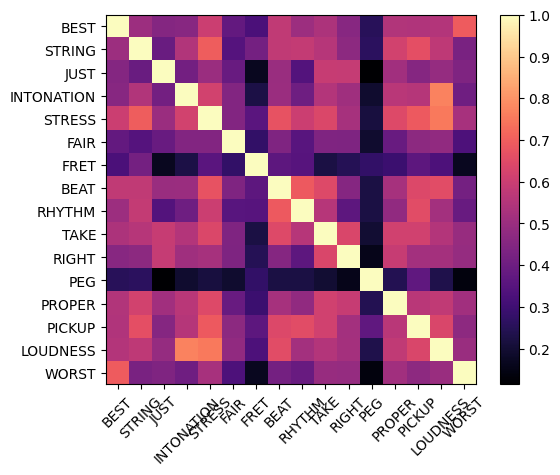

In [288]:
def normalized_dot_fn(x, y, eps=1e-8):
    """
    Cosine-like similarity: normalized dot product.
    Returns scalar.
    """
    nx = np.linalg.norm(x) + eps
    ny = np.linalg.norm(y) + eps
    return float((x @ y) / (nx * ny))

K1 = create_kernel_mat(words, normalized_dot_fn)
plot_kernel_mat(K1, words)

## Kernel function 2: RBF kernel

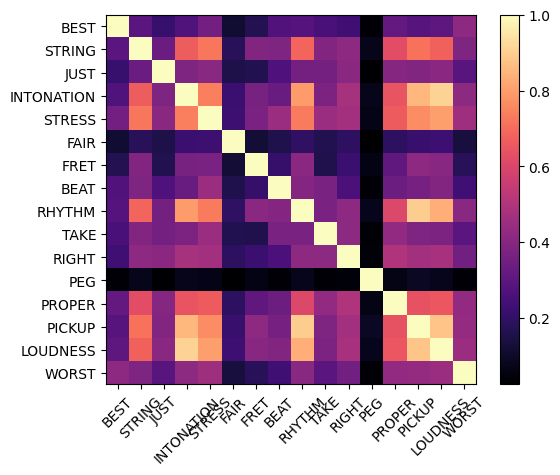

In [289]:
def rbf_kernel_fn(x, y, gamma):
    return np.exp(-gamma * np.linalg.norm(x - y)**2)

def compute_gamma(words, model):
    """
    Compute gamma = 1 / median(||x_i - x_j||^2)
    words: list of words
    model: dict mapping word -> vector
    """
    vecs = np.stack([model[w] for w in words], axis=0)  # (N, d)
    N = vecs.shape[0]

    dists2 = []
    for i in range(N):
        for j in range(i + 1, N):
            d2 = np.sum((vecs[i] - vecs[j]) ** 2)
            dists2.append(d2)

    median_dist2 = np.median(dists2)
    gamma = 1.0 / (median_dist2 + 1e-12)

    return gamma

K2 = create_kernel_mat(words, rbf_kernel_fn, gamma=compute_gamma(words, model))
plot_kernel_mat(K2, words)

## Algorithm to cluster the data

In [290]:
from sklearn.cluster import KMeans

def kmeans_order_from_K(K, n_clusters=4, random_state=0):
    """
    K: (N, N) similarity / kernel matrix
    returns:
        order: list of reordered indices
    """

    km = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = km.fit_predict(K)

    centers = km.cluster_centers_

    dist = np.linalg.norm(K - centers[labels], axis=1)
    order = np.argsort(labels + 1e-6 * dist)

    return order.tolist()

def apply_order(x, order):
    """
    x: (N, N) matrix OR (N,) vector/list
    order: list of indices

    returns:
        reordered x
    """
    order = np.asarray(order)
    x = np.asarray(x)

    if x.ndim == 2:
        return x[np.ix_(order, order)]
    elif x.ndim == 1:
        return x[order]
    else:
        raise ValueError("x must be 1D or 2D")

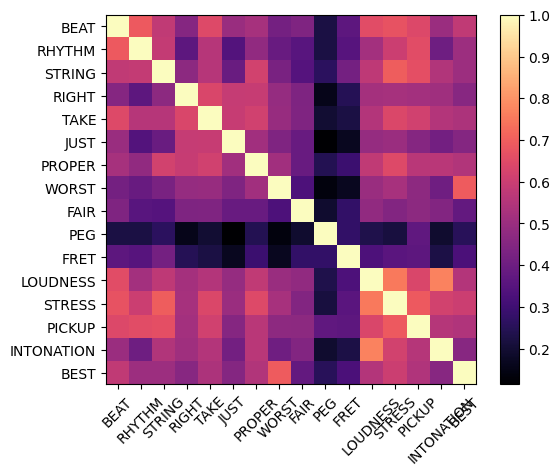

In [291]:
order = kmeans_order_from_K(K1, n_clusters=4)
K_sorted = apply_order(K1, order)
words_sorted = apply_order(words, order)

plot_kernel_mat(K_sorted, words_sorted)

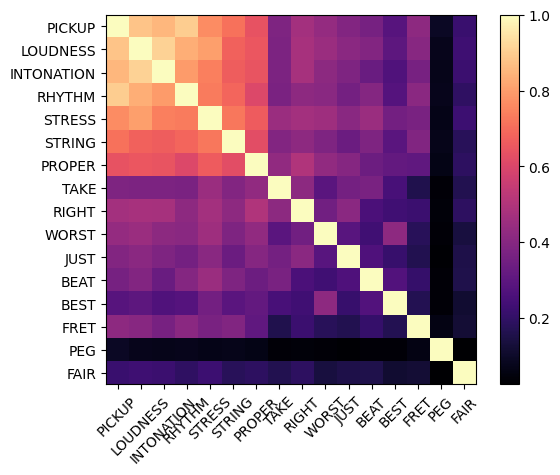

In [292]:
order = kmeans_order_from_K(K2, n_clusters=4)
K_sorted = apply_order(K2, order)
words_sorted = apply_order(words, order)

plot_kernel_mat(K_sorted, words_sorted)

In [293]:
import torch
from torch import nn

## Prepare data

In [300]:
data = []

for game in games:
    if np.nan in game['words']:
        continue

    X = torch.tensor(  # 16 x 300
        np.stack([model[word] for word in game['words']]),
        dtype=torch.float32
    )
    y = torch.tensor(game['labels'], dtype=torch.long)  # (16,)
    data.append((X, y, game['words']))

from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data,
                                         test_size=0.2,
                                         random_state=42)

data_train

[(tensor([[-0.0070, -0.0087, -0.0749,  ..., -0.0214, -0.0017,  0.0268],
          [-0.0041, -0.0241, -0.0477,  ...,  0.0019,  0.0365,  0.0178],
          [-0.0063, -0.0121, -0.0411,  ...,  0.0097,  0.0026, -0.0003],
          ...,
          [-0.0111, -0.0094, -0.0542,  ..., -0.0206, -0.0017, -0.0050],
          [-0.0030, -0.0124, -0.0206,  ..., -0.0043, -0.0084, -0.0022],
          [-0.0366, -0.0067, -0.0229,  ...,  0.0114, -0.0072,  0.0036]]),
  tensor([1, 2, 3, 2, 3, 0, 1, 3, 1, 0, 2, 0, 2, 1, 0, 3]),
  ['SUGAR',
   'ANGEL',
   'GINGER',
   'BIRD',
   'BABY',
   'CUMIN',
   'BOO',
   'SCARY',
   'SWEETIE',
   'CORIANDER',
   'AIRPLANE',
   'CLOVE',
   'PEGASUS',
   'HONEY',
   'CARDAMOM',
   'POSH']),
 (tensor([[-0.0240, -0.0031, -0.0433,  ...,  0.0241, -0.0276,  0.0086],
          [-0.0070, -0.0094, -0.0407,  ..., -0.0309,  0.0018, -0.0040],
          [-0.1578,  0.0035, -0.0369,  ..., -0.0641,  0.0282,  0.0313],
          ...,
          [ 0.0050,  0.0104, -0.0630,  ..., -0.0556,  0.

## Build model

In [301]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class LinearKernel(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.layer = nn.Linear(in_features=d, out_features=d, bias=False)

    def forward(self, x):
        return self.layer(x)

kernel = LinearKernel(300).to(device)
kernel

LinearKernel(
  (layer): Linear(in_features=300, out_features=300, bias=False)
)

## Train & Test Loop

In [302]:
import torch.nn.functional as F

optimizer = torch.optim.Adam(kernel.parameters(), lr=0.01)

epochs = 51
loss_list = []

for epoch in range(epochs):
    kernel.train()
    total_loss = 0

    for X_train, y_train, words_train in data_train:
        X_train, y_train = X_train.to(device), y_train.to(device)

        Z = kernel(X_train)  # kernel calculates each row of X_train
        Z = F.normalize(Z, p=2, dim=1)
        K = Z @ Z.T  # calculate the kernel matrix

        D = (y_train[:, None] == y_train[None, :]).float().to(Z.device)
        loss = ((K - D)**2).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg = total_loss / len(data_train)
    loss_list.append(avg)
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"epoch {epoch}  avg_loss={avg:.3f}")

epoch 0  avg_loss=0.166
epoch 10  avg_loss=0.128
epoch 20  avg_loss=0.124
epoch 30  avg_loss=0.122
epoch 40  avg_loss=0.121
epoch 50  avg_loss=0.120


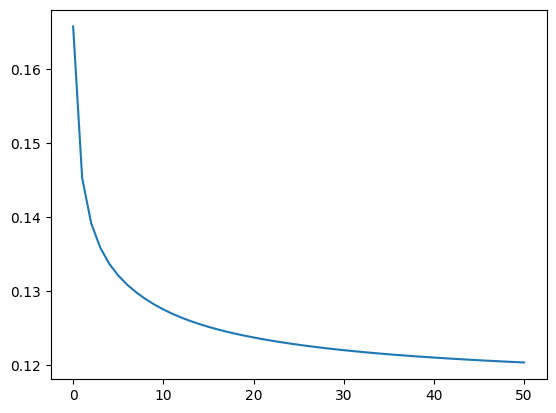

In [303]:
plt.plot(loss_list)
plt.show()

In [297]:
kernel.eval()
X0, y0, words_test = data_test[0]
X0 = X0.to(device)
with torch.inference_mode():
    Z0 = kernel(X0)
    Z0 = F.normalize(Z0, dim=1)
    K0 = (Z0 @ Z0.t()).cpu().numpy()

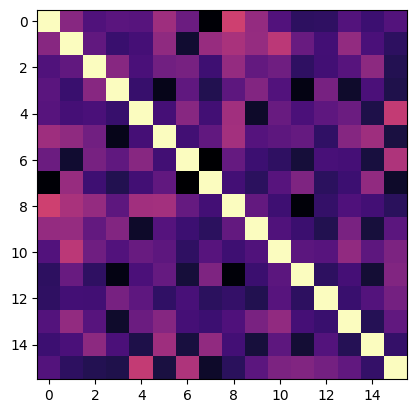

In [298]:
plt.imshow(K0, cmap='magma')

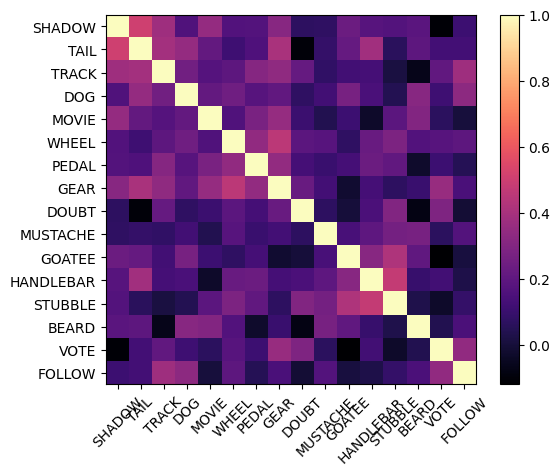

In [299]:
order = kmeans_order_from_K(K0, n_clusters=4)
K_sorted = apply_order(K0, order)
words_sorted = apply_order(words_test, order)

plot_kernel_mat(K_sorted, words_sorted)